In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.optimize import curve_fit,differential_evolution
from scipy.special import erf
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.integrate import quad
import matplotx
import os
from datetime import datetime
from src import *
plt.style.use(matplotx.styles.pitaya_smoothie["light"])

In [18]:
data_in=r"C:\Users\chem-chem1918\OneDrive\Documents\2_Master\5_Labrotations\AK-Rauschenbach\Data\Proteasome\20241219_XL-PA28ab_MP\003_20241219_120_XL-PA28ab_denat_dil_navg15.csv"

df=pd.read_csv(data_in,comment='#')
data=df[df["calibrated_values"]>0]["calibrated_values"].sort_values(ascending=True).to_numpy()


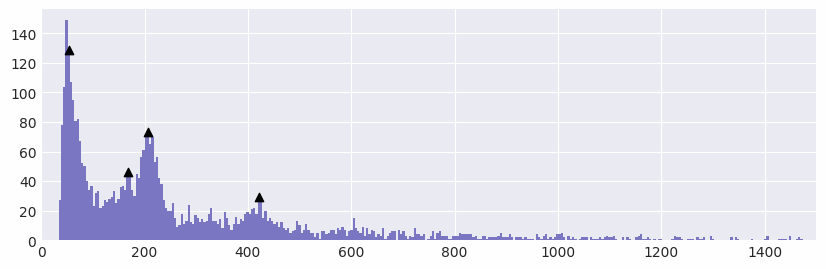

In [34]:
bins=6000
threshold=20
peak_est,properties=get_peak_estimates(
    data=data,
    bins=bins,
    min_dist_Da=20,
    height=threshold,
    smooth=1.5
    )

bounds=generate_bounds(peak_estimate=peak_est.T)
fig,ax=plt.subplots(figsize=(10,3))
ax.hist(data,bins=bins)
N=peak_est.size //3
ax.scatter(peak_est.T[1],peak_est.T[0],marker="^",color="k")
ax.set(xlim=(0,1500));

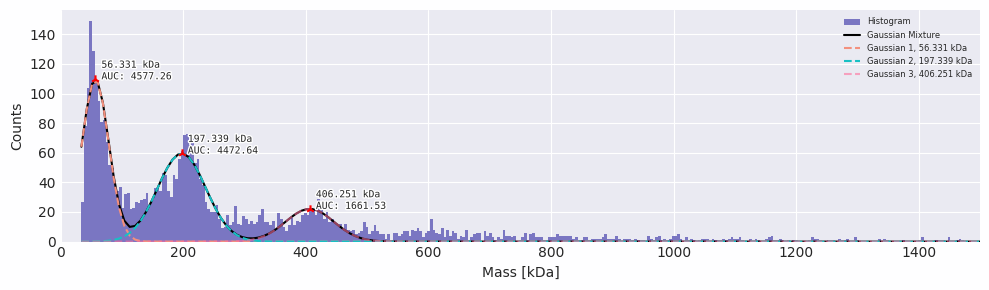

In [35]:
"""Using the bin-centers of the histogram -> fit depends on binning
"""

initial_guess=peak_est.flatten()


counts, bin_edges = make_histogram(data,bins=bins,density=False)
bin_centers = get_bin_centers(bin_edges=bin_edges)

# Fit the histogram data
params_flat, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess,maxfev=5000,bounds=bounds.T)
params=np.reshape(params_flat,shape=(-1,3))
params=params[params[:,0]>threshold]
para_df=pd.DataFrame({"amplitude":params[:,0],"mu":params[:,1],"sigma":params[:,2],"auc":np.zeros(params.shape[0])})

# Generate points for plotting
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 3000)
y_fit = multi_gaussian(x_fit, *params_flat)

fig, ax=plt.subplots(figsize=(10,3))
# Plot the histogram
ax.hist(data, bins=bins, label="Histogram")
# Plot the fitted Gaussians
ax.plot(x_fit, y_fit, 'k-', label="Gaussian Mixture")
# Plot individual components

for i,para in para_df.iterrows():
    y_individual = gauss(x_fit,para.amplitude,para.mu,para.sigma)
    para_df.loc[i,"auc"]=auc_gaussian_fwhm(para.amplitude,para.mu,para.sigma)
    ax.plot(x_fit, y_individual, '--', label=f"Gaussian {i + 1}, {para.mu:.3f} kDa")
    ax.text(para.mu+10,para.amplitude,f"{para.mu:.3f} kDa\nAUC: {para.auc:.2f}",size=7,fontfamily="monospace",path_effects=[pe.withStroke(linewidth=2, foreground="white")],verticalalignment="baseline",clip_on=True)
ax.scatter(para_df.mu,para_df.amplitude,marker="2",color="r",zorder=10)
ax.legend(prop={'size': 6})
ax.set(ylabel="Counts",xlabel="Mass [kDa]",xlim=[0,1500]);
fig.tight_layout()


In [21]:
folder=make_output_folder(data_in=data_in,folder_name="XL_MP")
para_df.to_csv(fr"{folder}\{os.path.basename(data_in)}")
fig.savefig(fr"{folder}\{os.path.basename(data_in).split(".")[0]}.png",dpi=300)
fig.savefig(fr"{folder}\{os.path.basename(data_in).split(".")[0]}.svg",dpi=300)


In [22]:
"""Using the Cumulative Distribution Function -> not as stable for fitting
"""

# bounds=generate_bounds(peak_est) # Changed function to transpose data -> needs to be fixed before using this here
# params_opt=differential_evolution(target_function,bounds=bounds,maxiter=100, polish=True, atol=1).x
# # Extract optimized parameters
# N = len(params_opt) // 3
# A_opt = params_opt[:N]
# mu_opt = params_opt[N:2*N]
# sigma_opt = params_opt[2*N:3*N]

# x = np.linspace(data[0,0], data[0,-1], 5000) # data is a 1d array currently (comment in the lines in ht efirst block)

# fig, ax = plt.subplots(2,figsize=(10,5),sharex="all")
# ax[0].hist(data[0], bins=bins, density=True, label='Histogram (PDF)',color="salmon",alpha=0.5)
# ax[0].set(xlim=(0, 1500))

# gauss_sum=0
# for A,u,sig in zip(A_opt,mu_opt,sigma_opt):
#     fit_gauss= gauss(x,A,u,sig)
#     ax[0].plot(x,fit_gauss,label=f"{u:.3f}")
#     gauss_sum+=fit_gauss

# ax[0].plot(x,gauss_sum, label="Cumulative PDF Fit")
# ax[0].legend()

# ax[1].plot(data[0], data[1], 'r', label='Empirical CDF')
# ax[1].plot(x, cumulative_gaussian_mixture(x, *params_opt), "k--",label='Fitted CDF',alpha=0.5)
# ax[1].legend()


'Using the Cumulative Distribution Function -> not as stable for fitting\n'